### Spam SMS Detection

We'll explore techniques for detecting spam SMS messages. Spam detection is an essential task in natural language processing and text classification


Section 1 - In this section, I implement Machine Learning techniques to find out a message is spam or not. Then, the model is exported using the joblib library. Later, I create a front end to consume the pickle file and predict in real-time whether a message is a spam or a ham. Application link - https://spam-sms-detect-nlp.herokuapp.com/

Section 2 - Transformers are python based libraries. In this section, I use a pre-trained Natural Language Understanding (NLU) model - DistilBERT from Hugging Face, and fine-tune it locally to best suit our dataset. In the last stage, the model is evaluated on test data.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import chardet
import nltk
import wordcloud
import warnings
# Ignore the warning
warnings.filterwarnings('ignore')

In [ ]:
# Load the dataset
df = pd.read_csv('spam.csv', encoding='latin-1')
df.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [ ]:
# drop columns having NaN values
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
df.shape

(5572, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
df.rename(columns={'v1':'target','v2':'text'},inplace=True) ## change the columns name from v1 , v2 to target and text
df

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
df['target'] = le.fit_transform(df['target'])
df

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


"After applying label encoding, the target values are transformed such that 'ham' is encoded as 0 and 'spam' is encoded as 1."

In [ ]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [ ]:
df.duplicated().sum()

403

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.shape

(5169, 2)

In [ ]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.target.value_counts()

target
0    4516
1     653
Name: count, dtype: int64

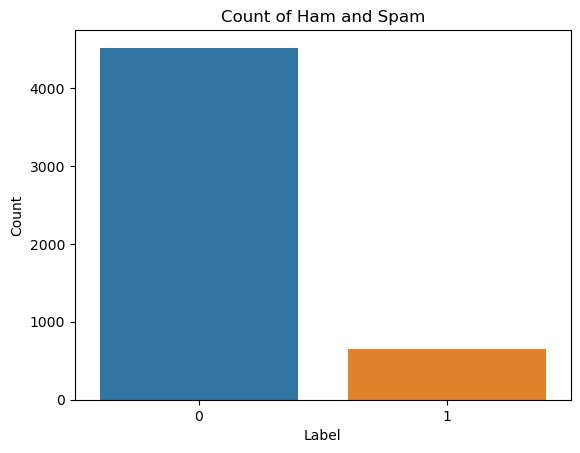

In [ ]:
sns.countplot(data = df, x= 'target')
# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Ham and Spam')
plt.show()

From above plot it can be seen that the data is so much imbalanced

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Test\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df.loc[:, 'num_characters'] = df['text'].apply(len)
df

,target,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161
5568,0,Will Ì_ b going to esplanade fr home?,37
5569,0,"Pity, * was in mood for that. So...any other s...",57
5570,0,The guy did some bitching but I acted like i'd...,125


create a new column num_characters to the dataframe df, where each value in this column represents the number of characters in the corresponding message in the text column. This can be useful for analyzing the length of messages.

In [ ]:
df.loc[:, 'num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df

,target,text,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,35
5568,0,Will Ì_ b going to esplanade fr home?,37,9
5569,0,"Pity, * was in mood for that. So...any other s...",57,15
5570,0,The guy did some bitching but I acted like i'd...,125,27


The code adds a new column, num_words, to the dataframe df, which contains the number of words in each text message.

In [ ]:
df.loc[:, 'num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))
df

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,35,4
5568,0,Will Ì_ b going to esplanade fr home?,37,9,1
5569,0,"Pity, * was in mood for that. So...any other s...",57,15,2
5570,0,The guy did some bitching but I acted like i'd...,125,27,1


create a new column to the dataframe called 'num_sentences', which represents the number of sentences in each text entry. It utilizes the apply function along with a lambda function to apply the nltk.sent_tokenize() function to each text entry in the 'text' column, calculating the length of the resulting list of sentences.

In [ ]:
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [ ]:
df[df['target'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [ ]:
df[df['target'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


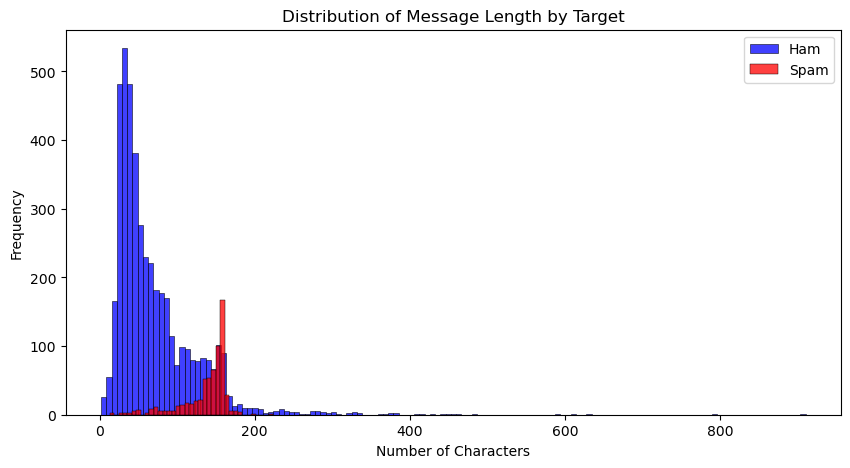

In [ ]:
# Set figure size
plt.figure(figsize=(10,5))

# Plot histogram for 'ham' messages (Label 0)
sns.histplot(df[df['target'] == 0]['num_characters'], color='blue', label='Ham')

# Plot histogram for 'spam' messages (Label 1)
sns.histplot(df[df['target'] == 1]['num_characters'], color='red', label='Spam')

# Add labels and title
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.title('Distribution of Message Length by Target')
plt.legend()  # Show legend
plt.show()

The graph shows that the distribution of message lengths can be used to distinguish between ham and spam messages,with spam massages being more likely to be shorter than ham massages

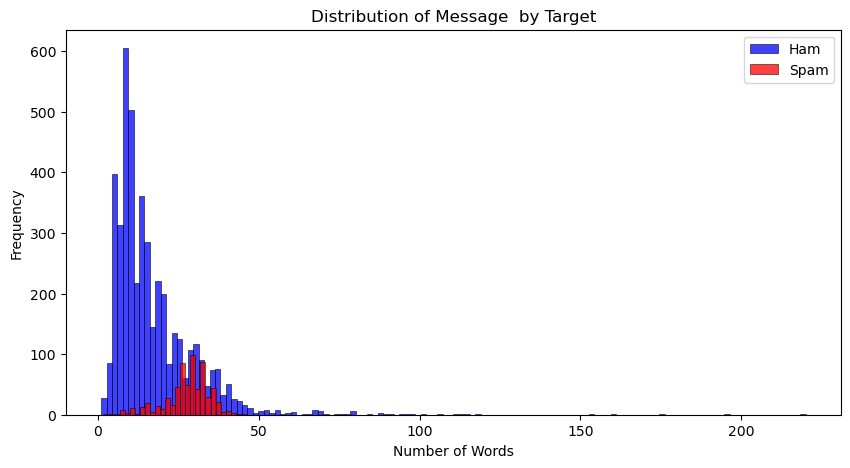

In [ ]:
plt.figure(figsize=(10,5))

# Plot histograms for 'ham' and 'spam' messages
sns.histplot(df[df['target'] == 0]['num_words'], label='Ham', color='blue')
sns.histplot(df[df['target'] == 1]['num_words'], label='Spam', color='red')

# Add labels and title
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Message  by Target')
plt.legend()
plt.show()

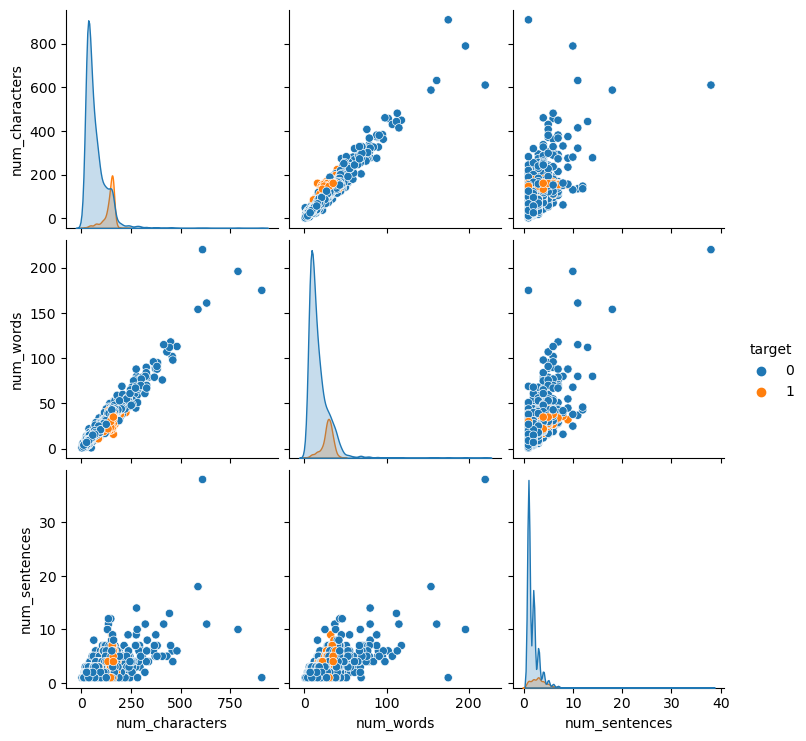

In [ ]:
sns.pairplot(df,hue='target')

### Data Processing

In [ ]:
pip install wordninja

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Libraries needed for NLP
import nltk
import re

# Stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Stemmers
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

# Lemmatizer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from bs4 import BeautifulSoup
import string
import wordninja as wn #Probabilistically split concatenated words
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob # TextBlob works amazingly as a sentiment analyzer.
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Test\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Test\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Test\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from nltk.corpus import stopwords
allstopwords = stopwords.words('english')

In [ ]:
# Store it in a variable
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocessing(sentence):
    # make smallercase
    sentence = sentence.lower()

    # remove emails
    sentence = re.sub(r"([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", '', sentence)

    # remove mentions
    sentence = re.sub(r"@[A-Za-z0-9]+","", sentence)

    # Remove html
    sentence = BeautifulSoup(sentence, 'lxml').get_text().strip()

    # Remove URL
    sentence = re.sub(r'https?://\S+|www\.\S+', '', sentence)

    # Removing punctutation
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))

    # Remove non-alphabetic characters
    sentence = re.sub(r'[^a-zA-Z ]', '', sentence)

    # Spliting words into two meaningful word
    sentence = ' '.join(wn.split(str(sentence)))

    #Correct the sentence
    sentence =  str(TextBlob(sentence).correct())
 # decontracted

    ## specific
    sentence = re.sub(r"wont", "will not", sentence)
    sentence = re.sub(r"wouldnt", "would not", sentence)
    sentence = re.sub(r"shouldnt", "should not", sentence)
    sentence = re.sub(r"couldnt", "could not", sentence)
    sentence = re.sub(r"cudnt", "could not", sentence)
    sentence = re.sub(r"cant", "can not", sentence)
    sentence = re.sub(r"dont", "do not", sentence)
    sentence = re.sub(r"doesnt", "does not", sentence)
    sentence = re.sub(r"didnt", "did not", sentence)
    sentence = re.sub(r"wasnt", "was not", sentence)
    sentence = re.sub(r"werent", "were not", sentence)
    sentence = re.sub(r"havent", "have not", sentence)
    sentence = re.sub(r"hadnt", "had not", sentence)

    ## general
    sentence = re.sub(r"n\ t", " not", sentence)
    sentence = re.sub(r"\re", " are", sentence)
    sentence = re.sub(r"\ s ", " is ", sentence)
    sentence = re.sub(r"\ d ", " would ", sentence)
    sentence = re.sub(r"\ ll ", " will ", sentence)
    sentence = re.sub(r"\dunno", "do not ", sentence)
    sentence = re.sub(r"ive ", "i have ", sentence)
    sentence = re.sub(r"im ", "i am ", sentence)
    sentence = re.sub(r"i m ", "i am ", sentence)
    sentence = re.sub(r" w ", " with ", sentence)

    # Punctuation Removal
    sentence = "".join(i for i in sentence if i not in string.punctuation)
    # Stop Word Removal
    sentence = " ".join(i for i in sentence.split() if i not in allstopwords)


    # Lemmatize
    lm = WordNetLemmatizer()
    snt = ' '.join([lm.lemmatize(i) for i in sentence.split()])
    return snt

In [ ]:
# Apply the preprocessing to the 'Text' column
df['Cleaned_Text'] = df['text'].apply(preprocessing)
df.head()

,target,text,num_characters,num_words,num_sentences,Cleaned_Text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go point crazy available boris n great world l...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok war joking u
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry k ly come win cup final st may text...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say early u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,ah think go u life around though


### Modeling

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

In [ ]:
X = tfidf.fit_transform(df['Cleaned_Text']).toarray()
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
tfidf_data = pd.DataFrame(X)
tfidf_data.head()

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X.shape

(5169, 3000)

In [ ]:
y = df['target'].values
y

array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [ ]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [ ]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [ ]:
# Training the models
gnb.fit(X_train, y_train)

GaussianNB()

In [ ]:
GaussianNB()

GaussianNB()

In [ ]:
mnb.fit(X_train, y_train)

MultinomialNB()

In [ ]:
MultinomialNB()

MultinomialNB()

In [ ]:
bnb.fit(X_train, y_train)

BernoulliNB()

In [ ]:
BernoulliNB()

BernoulliNB()

In [ ]:
# Predictions
gnb_preds = gnb.predict(X_test)
mnb_preds = mnb.predict(X_test)
bnb_preds = bnb.predict(X_test)

In [ ]:
# Accuracy scores
gnb_accuracy = accuracy_score(y_test, gnb_preds)
mnb_accuracy = accuracy_score(y_test, mnb_preds)
bnb_accuracy = accuracy_score(y_test, bnb_preds)

In [ ]:
# Confusion matrices
gnb_confusion = confusion_matrix(y_test, gnb_preds)
mnb_confusion = confusion_matrix(y_test, mnb_preds)
bnb_confusion = confusion_matrix(y_test, bnb_preds)

In [ ]:
# Precision scores
gnb_precision = precision_score(y_test, gnb_preds)
mnb_precision = precision_score(y_test, mnb_preds)
bnb_precision = precision_score(y_test, bnb_preds)

In [ ]:
print("Gaussian Naive Bayes:")
print("Accuracy:", gnb_accuracy)
print("Confusion Matrix:\n", gnb_confusion)
print("Precision:", gnb_precision)

Gaussian Naive Bayes:
Accuracy: 0.8336557059961315
Confusion Matrix:
 [[756 140]
 [ 32 106]]
Precision: 0.43089430894308944


In [ ]:
print("\nMultinomial Naive Bayes:")
print("Accuracy:", mnb_accuracy)
print("Confusion Matrix:\n", mnb_confusion)
print("Precision:", mnb_precision)


Multinomial Naive Bayes:
Accuracy: 0.9700193423597679
Confusion Matrix:
 [[895   1]
 [ 30 108]]
Precision: 0.9908256880733946


In [ ]:
print("\nBernoulli Naive Bayes:")
print("Accuracy:", bnb_accuracy)
print("Confusion Matrix:\n", bnb_confusion)
print("Precision:", bnb_precision)


Bernoulli Naive Bayes:
Accuracy: 0.9796905222437138
Confusion Matrix:
 [[890   6]
 [ 15 123]]
Precision: 0.9534883720930233


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [ ]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [ ]:
clfs = {
    'SVC' : svc,
    'KN' : knc,
    'NB': mnb,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'AdaBoost': abc,
    'BgC': bc,
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [ ]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)

    return accuracy,precision

In [ ]:
train_classifier(svc,X_train,y_train,X_test,y_test)

(0.9787234042553191, 0.967741935483871)

In [ ]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():

    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)

    print("For ",name,":")
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)

    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC :
Accuracy -  0.9787234042553191
Precision -  0.967741935483871
For  KN :
Accuracy -  0.913926499032882
Precision -  1.0
For  NB :
Accuracy -  0.9700193423597679
Precision -  0.9908256880733946
For  DT :
Accuracy -  0.941972920696325
Precision -  0.8545454545454545
For  LR :
Accuracy -  0.9632495164410058
Precision -  0.9385964912280702
For  RF :
Accuracy -  0.97678916827853
Precision -  1.0
For  AdaBoost :
Accuracy -  0.9709864603481625
Precision -  0.9576271186440678
For  BgC :
Accuracy -  0.9632495164410058
Precision -  0.8676470588235294
For  ETC :
Accuracy -  0.9787234042553191
Precision -  0.967741935483871
For  GBDT :
Accuracy -  0.9584139264990329
Precision -  0.9439252336448598
For  xgb :
Accuracy -  0.97678916827853
Precision -  0.9596774193548387


In [ ]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)
performance_df

,Algorithm,Accuracy,Precision
1,KN,0.913926,1.000000
5,RF,0.976789,1.000000
2,NB,0.970019,0.990826
0,SVC,0.978723,0.967742
8,ETC,0.978723,0.967742
10,xgb,0.976789,0.959677
6,AdaBoost,0.970986,0.957627
9,GBDT,0.958414,0.943925
4,LR,0.963250,0.938596
7,BgC,0.963250,0.867647


In [ ]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")
performance_df1

,Algorithm,variable,value
0,KN,Accuracy,0.913926
1,RF,Accuracy,0.976789
2,NB,Accuracy,0.970019
3,SVC,Accuracy,0.978723
4,ETC,Accuracy,0.978723
5,xgb,Accuracy,0.976789
6,AdaBoost,Accuracy,0.970986
7,GBDT,Accuracy,0.958414
8,LR,Accuracy,0.963250
9,BgC,Accuracy,0.963250


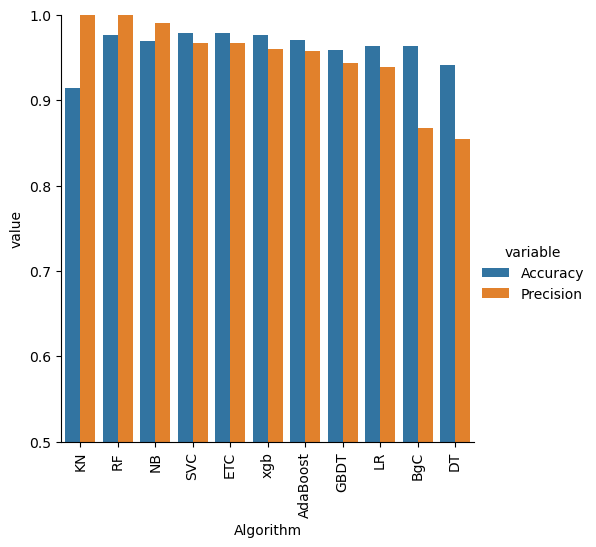

In [ ]:
sns.catplot(x = 'Algorithm', y='value',
               hue = 'variable',data=performance_df1, kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
# Voting Classifier
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

from sklearn.ensemble import VotingClassifier

In [ ]:
voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('et', etc)],voting='soft')

In [ ]:
voting.fit(X_train,y_train)

VotingClassifier(estimators=[('svm',
                              SVC(gamma=1.0, kernel='sigmoid',
                                  probability=True)),
                             ('nb', MultinomialNB()),
                             ('et',
                              ExtraTreesClassifier(n_estimators=50,
                                                   random_state=2))],
                 voting='soft')

In [ ]:
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9845261121856866
Precision 0.9841269841269841


In [ ]:
# Now we will apply stacking
estimators=[('svm', svc), ('nb', mnb), ('et', etc)]
final_estimator=RandomForestClassifier()

In [ ]:
from sklearn.ensemble import StackingClassifier

In [ ]:
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [ ]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9845261121856866
Precision 0.9692307692307692


In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

params = {'alpha': [0.01, 0.1, 0.19, 0.195, 0.18, 0.17, 0.21, 0.22, 0.23, 0.24, 0.2, 0.3, 0.5, 1.0, 2, 3, 4, 10.0]}

cv = KFold(n_splits=18, random_state=42, shuffle=True)
clfgs = GridSearchCV(mnb, params, cv=cv, n_jobs=-1, scoring='accuracy')

clfgs.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=18, random_state=42, shuffle=True),
             estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.19, 0.195, 0.18, 0.17, 0.21,
                                   0.22, 0.23, 0.24, 0.2, 0.3, 0.5, 1.0, 2, 3,
                                   4, 10.0]},
             scoring='accuracy')

In [ ]:
y_pred=clfgs.predict(X_test)
print('Confusion Matrix:\n', confusion_matrix(y_test,y_pred))
print('-----------------------------------------------------------------------')
print('Accuracy Score:', accuracy_score(y_test,y_pred))
print('-----------------------------------------------------------------------')

# Predicting and calculating f1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_pred, y_test)
f1_round = round(f1,2)

print('F1 score:',f1_round)
print('-----------------------------------------------------------------------')
print('Classification Report:')
print('\n',classification_report(y_test,y_pred))
print('-----------------------------------------------------------------------')

Confusion Matrix:
 [[892   4]
 [ 16 122]]
-----------------------------------------------------------------------
Accuracy Score: 0.9806576402321083
-----------------------------------------------------------------------
F1 score: 0.92
-----------------------------------------------------------------------
Classification Report:

               precision    recall  f1-score   support

           0       0.98      1.00      0.99       896
           1       0.97      0.88      0.92       138

    accuracy                           0.98      1034
   macro avg       0.98      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034

-----------------------------------------------------------------------


In [ ]:
print('Training Accuracy : %.3f' %clfgs.score(X_train, y_train))
print('Test Accuracy : %.3f' %clfgs.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f' %clfgs.best_score_)
print('Best Parameters : ', clfgs.best_params_)

Training Accuracy : 0.989
Test Accuracy : 0.981
Best Accuracy Through Grid Search : 0.979
Best Parameters :  {'alpha': 0.21}


In [ ]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr, tpr, thresh = roc_curve(y_test, y_pred, pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

from sklearn.metrics import roc_auc_score

# auc score
auc_score = roc_auc_score(y_test, y_pred)

print(auc_score)

0.9397968426501035


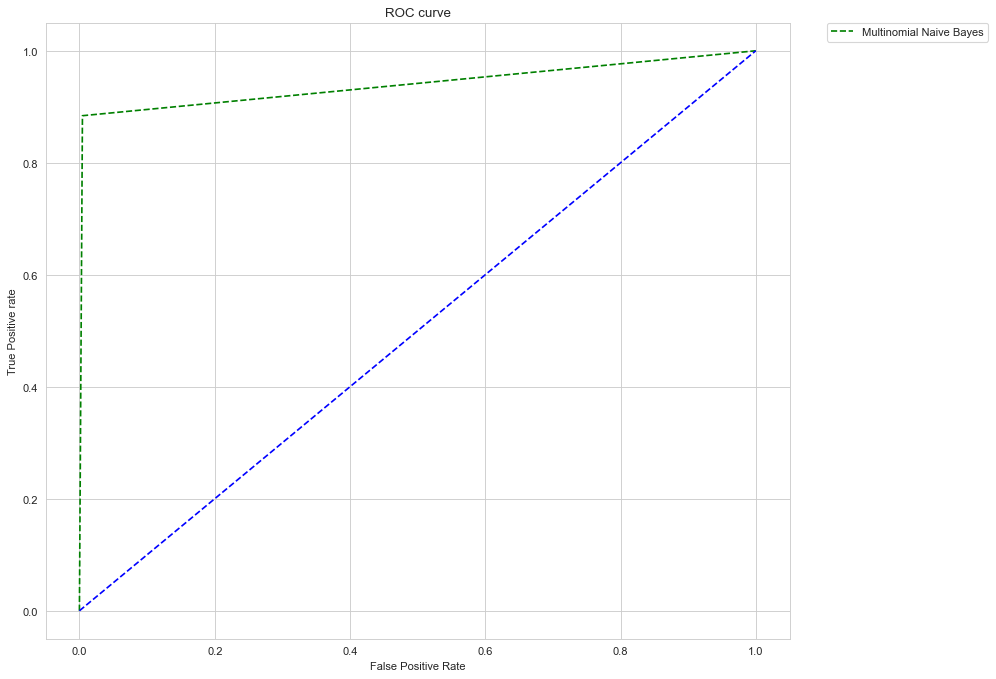

In [ ]:
# Matplotlib
import matplotlib.pyplot as plt

# Seaborn
import seaborn as sns
sns.set_style("whitegrid")

# Changing image size
from matplotlib.pyplot import figure
figure(figsize=(12, 10), dpi=80)

# Plot roc curves
plt.plot(fpr, tpr, linestyle='--', color='green', label='Multinomial Naive Bayes')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# Title
plt.title('ROC curve')

# X-label
plt.xlabel('False Positive Rate')

# Y-label
plt.ylabel('True Positive rate')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Light GBM

In [ ]:
import lightgbm as lgb

def train_and_test(model, model_name):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f2 = round(f1_score(pred, y_test),3)
    print(f'F1 score is: ',f2)

for depth in (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19):
    lgbmodel = lgb.LGBMClassifier(max_depth=depth, n_estimators=200,alpha=0.1,num_leaves=74)
    print(f"Max Depth {depth}")
    train_and_test(lgbmodel, "Light GBM")
    print("____________________________________")

Max Depth 1
F1 score is:  0.822
____________________________________
Max Depth 2
F1 score is:  0.882
____________________________________
Max Depth 3
F1 score is:  0.891
____________________________________
Max Depth 4
F1 score is:  0.899
____________________________________
Max Depth 5
F1 score is:  0.908
____________________________________
Max Depth 6
F1 score is:  0.913
____________________________________
Max Depth 7
F1 score is:  0.913
____________________________________
Max Depth 8
F1 score is:  0.913
____________________________________
Max Depth 9
F1 score is:  0.917
____________________________________
Max Depth 10
F1 score is:  0.917
____________________________________
Max Depth 11
F1 score is:  0.921
____________________________________
Max Depth 12
F1 score is:  0.913
____________________________________
Max Depth 13
F1 score is:  0.917
____________________________________
Max Depth 14
F1 score is:  0.917
____________________________________
Max Depth 15
F1 score is:  0.

In [ ]:
y_pred=lgbmodel.predict(X_test)
print('Confusion Matrix:\n', confusion_matrix(y_test,y_pred))
print('-----------------------------------------------------------------------')
print('Accuracy Score:', accuracy_score(y_test,y_pred))
print('-----------------------------------------------------------------------')

#Predicting and calculating f1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_pred, y_test)
f1_round = round(f1,3)

print('F1 score:',f1_round)
print('-----------------------------------------------------------------------')
print('Classification Report:')
print('\n',classification_report(y_test,y_pred))
print('-----------------------------------------------------------------------')

Confusion Matrix:
 [[891   5]
 [ 18 120]]
-----------------------------------------------------------------------
Accuracy Score: 0.9777562862669246
-----------------------------------------------------------------------
F1 score: 0.913
-----------------------------------------------------------------------
Classification Report:

               precision    recall  f1-score   support

           0       0.98      0.99      0.99       896
           1       0.96      0.87      0.91       138

    accuracy                           0.98      1034
   macro avg       0.97      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034

-----------------------------------------------------------------------


In [ ]:
print('Training Accuracy : %.3f' %lgbmodel.score(X_train, y_train))
print('Test Accuracy : %.3f' %lgbmodel.score(X_test, y_test))

Training Accuracy : 1.000
Test Accuracy : 0.978


In [ ]:
# roc curve for models
fpr, tpr, thresh = roc_curve(y_test, y_pred, pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

from sklearn.metrics import roc_auc_score

# auc score
auc_score = roc_auc_score(y_test, y_pred)

print(auc_score)

0.9319924301242236


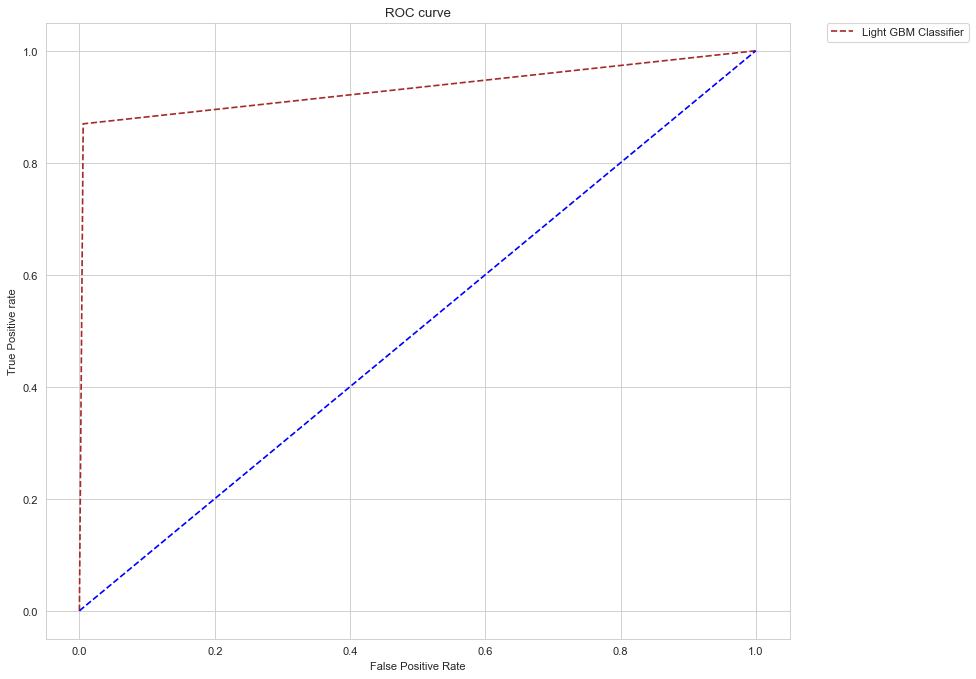

In [ ]:
import seaborn as sns
sns.set_style("whitegrid")

# Changing image size
from matplotlib.pyplot import figure
figure(figsize=(12, 10), dpi=80)

# Plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='brown', label='Light GBM Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# Title
plt.title('ROC curve')

# X-label
plt.xlabel('False Positive Rate')

# Y-label
plt.ylabel('True Positive rate')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
import pickle
#Exporting the model using joblib library
#import joblib
pickle.dump(clfgs,open('SMS_Detection_Model.pkl','wb'))

In [ ]:
#Exporting the model using joblib library
import joblib
#pickle.dump(tfidf,"vectorizer.pkl")
pickle.dump(tfidf,open('vectorizer.pkl','wb'))

### Section 2

In [ ]:
!pip install transformers

In [2]:
df2 = pd.read_csv('/content/spam.csv', encoding='latin-1')
df2.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# drop columns having NaN values
df2.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [4]:
df2.rename(columns={'v1':'target','v2':'text'},inplace=True) ## change the columns name from v1 , v2 to target and text
df2

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [5]:
X = list(df2['text'])

In [6]:
X

['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 'Ok lar... Joking wif u oni...',
 "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 'U dun say so early hor... U c already then say...',
 "Nah I don't think he goes to usf, he lives around here though",
 "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv",
 'Even my brother is not like to speak with me. They treat me like aids patent.',
 "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune",
 'WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.',
 'Had y

In [7]:
y = list(df2['target'])

In [8]:
y

['ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'spam',
 'spam',
 'ham',
 's

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df2['target'])

In [10]:
y

array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
!pip install torch

#### Tokenize the Text Data


In [11]:
# Import the torch module
import torch

from transformers import BertTokenizer

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data
encoded_inputs = tokenizer(X, padding=True, truncation=True, return_tensors='pt')
labels = torch.tensor(y.tolist())

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

#### Prepare the Dataset and DataLoader



In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

class SpamDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

dataset = SpamDataset(encoded_inputs, labels)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

#### Fine-tune BERT Model

Now, let's fine-tune the BERT model:

In [ ]:
from transformers import BertForSequenceClassification, AdamW

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
model.train()
for epoch in range(1):  # Train for 3 epochs
    for batch in dataloader:
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0, Loss: 0.4752378761768341
Epoch: 0, Loss: 0.31185469031333923
Epoch: 0, Loss: 0.19186854362487793
Epoch: 0, Loss: 0.16904158890247345
Epoch: 0, Loss: 0.10209902375936508
Epoch: 0, Loss: 0.0955629050731659
Epoch: 0, Loss: 0.09081271290779114
Epoch: 0, Loss: 0.05957620218396187
Epoch: 0, Loss: 0.051767922937870026
Epoch: 0, Loss: 0.03993735834956169
Epoch: 0, Loss: 0.03624005988240242
Epoch: 0, Loss: 0.026509426534175873
Epoch: 0, Loss: 0.021475104615092278
Epoch: 0, Loss: 0.02194298431277275
Epoch: 0, Loss: 0.018407976254820824
Epoch: 0, Loss: 0.014154022559523582
Epoch: 0, Loss: 0.012369959615170956
Epoch: 0, Loss: 0.00980426836758852
Epoch: 0, Loss: 0.007048389408737421
Epoch: 0, Loss: 0.007239718921482563
Epoch: 0, Loss: 0.0066267354413867
Epoch: 0, Loss: 0.006248301360756159
Epoch: 0, Loss: 0.005517533980309963
Epoch: 0, Loss: 0.005774584133177996
Epoch: 0, Loss: 0.00466844392940402
Epoch: 0, Loss: 0.0036403173580765724
Epoch: 0, Loss: 0.003953051287680864
Epoch: 0, Loss: 0

#### Evaluate the Model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to evaluate the model
def evaluate(model, dataloader):
  model.eval()
  preds, true_labels = [], []

  with torch.no_grad():
    for batch in dataloader:
      outputs = model(**batch)
      logits = outputs.logits
      preds.extend(torch.argmax(logits, dim=1).tolist())
      true_labels.extend(batch['labels'].tolist())

    accuracy = accuracy_score(true_labels, preds)
    precision = precision_score(true_labels, preds)
    recall = recall_score(true_labels, preds)
    f1 = f1_score(true_labels, preds)
    return accuracy, precision, recall, f1

#Evaluate the model
accuracy, precision, recall, f1 = evaluate(model, dataloader)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Other Way

Prepare Dataset for BERT

We'll convert the text data into the format required by BERT:

In [13]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

# Split the dataset into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)

### Create Custom Dataset

Create a custom dataset class for our training and validation sets:

In [14]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Create dataset objects
train_dataset = SpamDataset(train_encodings, train_labels.tolist())
val_dataset = SpamDataset(val_encodings, val_labels.tolist())

In [2]:
! pip install -U accelerate
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 5.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [15]:
!pip show accelerate

Name: accelerate
Version: 0.31.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [1]:
pip uninstall accelerate transformers

Found existing installation: transformers 4.41.2
Uninstalling transformers-4.41.2:
  Would remove:
    /usr/local/bin/transformers-cli
    /usr/local/lib/python3.10/dist-packages/transformers-4.41.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/transformers/*
Proceed (Y/n)? Y
  Successfully uninstalled transformers-4.41.2


### Fine-tune BERT Model

Now, let's fine-tune the BERT model:

In [16]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Load the pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=8,    # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Initialize Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

In [18]:
# Train the model
trainer.train()

Step,Training Loss
10,0.642500
20,0.586000
30,0.550500
40,0.488800
50,0.425400
60,0.342100
70,0.286200
80,0.210500
90,0.211500
100,0.115700


TrainOutput(global_step=558, training_loss=0.13136416942959378, metrics={'train_runtime': 11360.4017, 'train_samples_per_second': 0.392, 'train_steps_per_second': 0.049, 'total_flos': 545115745605480.0, 'train_loss': 0.13136416942959378, 'epoch': 1.0})

### Evaluate the Model

Finally, let's evaluate the model:

In [19]:
# Evaluate the model
results = trainer.evaluate()
print(results)

{'eval_loss': 0.03484870493412018, 'eval_runtime': 758.914, 'eval_samples_per_second': 1.469, 'eval_steps_per_second': 0.184, 'epoch': 1.0}


In [25]:
trainer.predict(val_dataset)

PredictionOutput(predictions=array([[ 3.0919611, -3.2914186],
       [ 3.0503757, -3.2432842],
       [-3.7531579,  3.7883966],
       ...,
       [ 3.1678813, -3.3418598],
       [ 3.184521 , -3.349098 ],
       [-3.755544 ,  3.7561038]], dtype=float32), label_ids=array([0, 0, 1, ..., 0, 0, 1]), metrics={'test_loss': 0.03484870493412018, 'test_runtime': 772.0653, 'test_samples_per_second': 1.444, 'test_steps_per_second': 0.181})

In [26]:
trainer.predict(val_dataset)[1].shape

(1115,)

In [28]:
output=trainer.predict(val_dataset)[1]

In [30]:
from sklearn.metrics import confusion_matrix
confusionMatrixResult=confusion_matrix(val_labels,output)
confusionMatrixResult

array([[965,   0],
       [  0, 150]])

In [32]:
from sklearn.metrics import classification_report
#predictions = np.argmax(trainer.predict(X_test_scaled), axis=-1)
print(classification_report(val_labels,output))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       965
           1       1.00      1.00      1.00       150

    accuracy                           1.00      1115
   macro avg       1.00      1.00      1.00      1115
weighted avg       1.00      1.00      1.00      1115



In [ ]:
# Save the model
trainer.save_model("./spam_classifier_model")
tokenizer.save_pretrained("./spam_classifier_model")

======================================

In [ ]:
# Creating a bag-of-words model
df_final = df['text']
from nltk.tokenize import word_tokenize

bow = []
for text in df_final:
    words = word_tokenize(text)
    for w in words:
        bow.append(w)

In [ ]:
# Implementing TF|IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer()
tfidf_vec=tfidf_model.fit_transform(df_final)
tfidf_data=pd.DataFrame(tfidf_vec.toarray())

In [ ]:
tfidf_data.head()

,0,1,2,3,4,5,6,7,8,9,...,8662,8663,8664,8665,8666,8667,8668,8669,8670,8671
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
